In [ ]:
#| default_exp utils

# Aggregation/Visualization Utils

The `HierarchicalForecast` package contains utility functions to wrangle and visualize 
hierarchical series datasets. The `aggregate` function of the module allows you to create
a hierarchy from categorical variables representing the structure levels, returning also
the aggregation contraints matrix $\mathbf{S}$.

In addition, `HierarchicalForecast` ensures compatibility of its reconciliation methods with other popular machine-learning libraries via its external forecast adapters that transform output base forecasts from external libraries into a compatible data frame format.

In [ ]:
#| export
import sys
import timeit
import warnings
from itertools import chain
from typing import Callable, Dict, List, Optional, Iterable, Union, Sequence

import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

plt.rcParams['font.family'] = 'serif'

In [ ]:
#| hide
from nbdev.showdoc import add_docs, show_doc
from fastcore.test import test_eq, test_close, test_fail

from statsforecast.utils import generate_series

In [ ]:
#| exporti
# Global variables
NUMBA_NOGIL = True
NUMBA_CACHE = True
NUMBA_PARALLEL = True
NUMBA_FASTMATH = True

In [ ]:
#| exporti
class CodeTimer:
    def __init__(self, name=None, verbose=True):
        self.name = " '"  + name + "'" if name else ''
        self.verbose = verbose

    def __enter__(self):
        self.start = timeit.default_timer()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (timeit.default_timer() - self.start)
        if self.verbose:
            print('Code block' + self.name + \
                  ' took:\t{0:.5f}'.format(self.took) + ' seconds')

In [ ]:
#| exporti
def is_strictly_hierarchical(S: np.ndarray, 
                             tags: Dict[str, np.ndarray]):
    # main idea:
    # if S represents a strictly hierarchical structure
    # the number of paths before the bottom level
    # should be equal to the number of nodes
    # of the previuos level
    levels_ = dict(sorted(tags.items(), key=lambda x: len(x[1])))
    # removing bottom level
    levels_.popitem()
    # making S categorical
    hiers = [np.argmax(S[idx], axis=0) + 1 for _, idx in levels_.items()]
    hiers = np.vstack(hiers)
    paths = np.unique(hiers, axis=1).shape[1] 
    nodes = levels_.popitem()[1].size
    return paths == nodes

In [ ]:
#| exporti
def cov2corr(cov, return_std=False):
    """ convert covariance matrix to correlation matrix

    **Parameters:**<br>
    `cov`: array_like, 2d covariance matrix.<br>
    `return_std`: bool=False, if True returned std.<br>

    **Returns:**<br>
    `corr`: ndarray (subclass) correlation matrix
    """
    cov = np.asanyarray(cov)
    std_ = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std_, std_)
    if return_std:
        return corr, std_
    else:
        return corr

# Aggregate Function

In [ ]:
#| exporti
def _to_summing_matrix(S_df: pd.DataFrame, sparse_s: bool = False):
    """Transforms the DataFrame `df` of hierarchies to a summing matrix S."""
    categories = [S_df[col].unique() for col in S_df.columns]
    cat_sizes = [len(cats) for cats in categories]
    idx_bottom = np.argmax(cat_sizes)
    cats_bottom = categories[idx_bottom]

    try:
        encoder = OneHotEncoder(categories=categories, sparse_output=sparse_s, dtype=np.float64)
    except TypeError:  # sklearn < 1.2
        encoder = OneHotEncoder(categories=categories, sparse=sparse_s, dtype=np.float64)

    S = encoder.fit_transform(S_df).T

    if sparse_s:
        df_constructor = pd.DataFrame.sparse.from_spmatrix
    else:
        df_constructor = pd.DataFrame
    S = df_constructor(S, index=chain(*categories), columns=cats_bottom)

    tags = dict(zip(S_df.columns, categories))
    return S, tags

In [ ]:
#| exporti
def aggregate_before(df: pd.DataFrame,
              spec: List[List[str]],
              agg_fn: Callable = np.sum,
              sparse_s: bool = False):
    """Utils Aggregation Function.

    Aggregates bottom level series contained in the pd.DataFrame `df` according
    to levels defined in the `spec` list applying the `agg_fn` (sum, mean).<br>

    **Parameters:**<br>
    `df`: pd.DataFrame with columns `['ds', 'y']` and columns to aggregate.<br>
    `spec`: List of levels. Each element of the list contains a list of columns of `df` to aggregate.<br>
    `agg_fn`: Function used to aggregate `'y'`.<br>
    `sparse_s`: bool=False, whether the returned S should be a sparse DataFrame.<br>


    **Returns:**<br>
    `Y_df, S, tags`: tuple with hierarchically structured series `Y_df` ($\mathbf{y}_{[a,b]}$),
    summing matrix `S`, and hierarchical aggregation indexes `tags`.
    """
    max_len_idx = np.argmax([len(hier) for hier in spec])
    bottom_comb = spec[max_len_idx]
    hiers = []
    for hier in spec:
        df_hier = df.groupby(hier + ['ds'])['y'].apply(agg_fn).reset_index()
        df_hier['unique_id'] = df_hier[hier].agg('/'.join, axis=1)
        if hier == bottom_comb:
            bottom_hier = df_hier['unique_id'].unique()
        hiers.append(df_hier)
    df_hiers = pd.concat(hiers)
    S_df = df_hiers[['unique_id'] + bottom_comb].drop_duplicates().reset_index(drop=True)
    S_df = S_df.set_index('unique_id')
    S_df = S_df.fillna('agg')
    hiers_cols = []
    for hier in spec:
        hier_col = '/'.join(hier)
        S_df[hier_col] = S_df[hier].agg('/'.join, axis=1)
        hiers_cols.append(hier_col)
    Y_df = df_hiers[['unique_id', 'ds', 'y']].set_index('unique_id')
    
    # Aggregations constraints S definition
    S, tags = _to_summing_matrix(S_df.loc[bottom_hier, hiers_cols], sparse_s)
    return Y_df, S, tags

In [ ]:
#| exporti
def _to_upper_hierarchy(bottom_split, bottom_values, upper_key):
    upper_split = upper_key.split('/')
    upper_idxs = [bottom_split.index(i) for i in upper_split]

    def join_upper(bottom_value):
        bottom_parts = bottom_value.split('/')
        return '/'.join(bottom_parts[i] for i in upper_idxs)

    return [join_upper(val) for val in bottom_values]

In [ ]:
#| export
def aggregate(
    df: pd.DataFrame,
    spec: List[List[str]],
    exog_vars: Optional[Dict[str, Union[str, List[str]]]] = None,
    is_balanced: bool = False,
    sparse_s: bool = False,
):
    """Utils Aggregation Function.
    Aggregates bottom level series contained in the pandas DataFrame `df` according
    to levels defined in the `spec` list.

    Parameters
    ----------
    df : pandas DataFrame
        Dataframe with columns `['ds', 'y']` and columns to aggregate.
    spec : list of list of str
        List of levels. Each element of the list should contain a list of columns of `df` to aggregate.
    exog_vars: dictionary of string keys & values that can either be a list of strings or a single string
        keys correspond to column names and the values represent the aggregation(s) that will be applied to each column. Accepted values are those from Pandas aggregation Functions, check the Pandas docs for guidance
    is_balanced : bool (default=False)
        Deprecated.
    sparse_s : bool (default=False)
        Return `S_df` as a sparse dataframe.

    Returns
    -------
    Y_df : pandas DataFrame
        Hierarchically structured series.
    S_df : pandas DataFrame
        Summing dataframe.
    tags : dict
        Aggregation indices.
    """
    # Checks
    if df.isnull().values.any():
        raise ValueError('`df` contains null values')
    if is_balanced:
        warnings.warn(
            "`is_balanced` is deprecated and will be removed in a future version. "
            "Don't set this argument to suppress this warning.",
            category=DeprecationWarning,
        )
         
            
    # compute aggregations and tags
    spec = sorted(spec, key=len)
    bottom = spec[-1]
    aggs = []
    tags = {}
    # Prepare the aggregation dictionary
    agg_dict = {
        "y": ("y", "sum")
    }


    # Check if exog_vars are present in df & add to the aggregation dictionary if it is not None
    if exog_vars is not None:
        missing_vars = [var for var in exog_vars.keys() if var not in df.columns]
        if missing_vars:
            raise ValueError(f"The following exogenous variables are not present in the DataFrame: {', '.join(missing_vars)}")    
        else:
          # Update agg_dict to handle multiple aggregations for each exog_vars key
            for key, agg_func in exog_vars.items():
                # Ensure agg_func is a list
                if isinstance(agg_func, str):  # If it's a single string, convert to list
                    agg_func = [agg_func]
                elif not isinstance(agg_func, list):  # Raise an error if it's neither
                    raise ValueError(f"Aggregation functions for '{key}' must be a string or a list of strings.")
                
                for func in agg_func:
                    agg_dict[f"{key}_{func}"] = (key, func)  # Update the agg_dict with the new naming structure

    # Perform the aggregation
    for levels in spec:
        agg = df.groupby(levels + ['ds'], observed=True).agg(**agg_dict)
        if not agg.index.is_monotonic_increasing:
            agg = agg.sort_index()
        agg = agg.reset_index('ds')
        group = agg.index.get_level_values(0)
        if not pd.api.types.is_string_dtype(group.dtype):
            group = group.astype(str)
        for level in levels[1:]:
            group = group + '/' + agg.index.get_level_values(level).str.replace('/', '_')
        agg.index = group
        agg.index.name = 'unique_id'
        tags['/'.join(levels)] = group.unique().values
        aggs.append(agg)
    Y_df = pd.concat(aggs)

    # construct S
    bottom_key = '/'.join(bottom)
    bottom_levels = tags[bottom_key]
    S = np.empty((len(bottom_levels), len(spec)), dtype=object)
    for j, levels in enumerate(spec[:-1]):
        S[:, j] = _to_upper_hierarchy(bottom, bottom_levels, '/'.join(levels))
    S[:, -1] = tags[bottom_key]
    categories = list(tags.values())
    try:
        encoder = OneHotEncoder(categories=categories, sparse_output=sparse_s, dtype=np.float64)
    except TypeError:  # sklearn < 1.2
        encoder = OneHotEncoder(categories=categories, sparse=sparse_s, dtype=np.float64)    
    S = encoder.fit_transform(S).T
    if sparse_s:
        df_constructor = pd.DataFrame.sparse.from_spmatrix
    else:
        df_constructor = pd.DataFrame
    S_df = df_constructor(S, index=np.hstack(categories), columns=bottom_levels)
    return Y_df, S_df, tags

In [ ]:
show_doc(aggregate, title_level=3)

---

[source](https://github.com/Nixtla/hierarchicalforecast/blob/main/hierarchicalforecast/utils.py#L153){target="_blank" style="float:right; font-size:smaller"}

### aggregate

>      aggregate (df:pandas.core.frame.DataFrame, spec:List[List[str]],
>                 exog_vars:Optional[Dict[str,Union[str,List[str]]]]=None,
>                 is_balanced:bool=False, sparse_s:bool=False)

*Utils Aggregation Function.
Aggregates bottom level series contained in the pandas DataFrame `df` according
to levels defined in the `spec` list.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | DataFrame |  | Dataframe with columns `['ds', 'y']` and columns to aggregate. |
| spec | List |  | List of levels. Each element of the list should contain a list of columns of `df` to aggregate. |
| exog_vars | Optional | None |  |
| is_balanced | bool | False | Deprecated. |
| sparse_s | bool | False | Return `S_df` as a sparse dataframe. |
| **Returns** | **pandas DataFrame** |  | **Hierarchically structured series.** |

In [ ]:
#| hide
# simple case
df = pd.DataFrame(
    {
        'cat1': ['a', 'a', 'a', 'b'],
        'cat2': ['1', '2', '3', '2'],
        'y': [10, 20, 30, 40],
        'ds': ['2020-01-01', '2020-02-01', '2020-03-01', '2020-02-01']
    }
)
df['country'] = 'COUNTRY'
spec = [['country'], ['country', 'cat1'], ['country','cat1', 'cat2']]
Y_df, S_df, tags = aggregate(df, spec)
test_eq(
    Y_df.index.tolist(), 
    3 * ['COUNTRY'] +
    3 * ['COUNTRY/a'] +
    ['COUNTRY/b'] +
    ['COUNTRY/a/1', 'COUNTRY/a/2', 'COUNTRY/a/3'] +
    ['COUNTRY/b/2']
)
test_eq(Y_df.loc['COUNTRY', 'y'].values, [10, 60, 30])
test_eq(
    S_df.index,
    ['COUNTRY', 'COUNTRY/a', 'COUNTRY/b', 'COUNTRY/a/1', 'COUNTRY/a/2', 'COUNTRY/a/3', 'COUNTRY/b/2'],
)
test_eq(
    S_df.columns,
    ['COUNTRY/a/1', 'COUNTRY/a/2', 'COUNTRY/a/3', 'COUNTRY/b/2'],
)
expected_tags = {
    'country': ['COUNTRY'],
    'country/cat1': ['COUNTRY/a', 'COUNTRY/b'],
    'country/cat1/cat2': ['COUNTRY/a/1', 'COUNTRY/a/2', 'COUNTRY/a/3','COUNTRY/b/2'],
}
for k, actual in tags.items():
    test_eq(actual, expected_tags[k])

# test categoricals don't produce all combinations
df2 = df.copy()
for col in ('country', 'cat1', 'cat2'):
    df2[col] = df2[col].astype('category')

Y_df2, *_ = aggregate(df2, spec)
assert Y_df.shape[0] == Y_df2.shape[0]

In [ ]:
#| hide
# test unbalanced dataset
max_tenure = 24
dates = pd.date_range(start='2019-01-31', freq='M', periods=max_tenure)
cohort_tenure = [24, 23, 22, 21]

ts_list = []

# Create ts for each cohort
for i in range(len(cohort_tenure)):
    ts_list.append(
        generate_series(n_series=1, freq='M', min_length=cohort_tenure[i], max_length=cohort_tenure[i]).reset_index() \
            .assign(ult=i) \
            .assign(ds=dates[-cohort_tenure[i]:]) \
            .drop(columns=['unique_id'])
    )
df = pd.concat(ts_list, ignore_index=True)

# Create categories
df['pen'] = np.where(df['ult'] < 2, 'a', 'b')
# Note that unique id requires strings
df['ult'] = df['ult'].astype(str)

hier_levels = [
    ['pen'],
    ['pen', 'ult'],
]

hier_df, S_df, tags = aggregate(df=df, spec=hier_levels)
hier_df_before, S_df_before, _ = aggregate_before(df=df, spec=hier_levels)
test_eq(S_df, S_df_before)
test_eq(hier_df, hier_df_before)

C:\Users\ospra\AppData\Local\Temp\ipykernel_11584\2004082394.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2019-01-31', freq='M', periods=max_tenure)
c:\Users\ospra\miniconda3\envs\hierarchicalforecast\lib\site-packages\utilsforecast\data.py:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ospra\miniconda3\envs\hierarchicalforecast\lib\site-packages\utilsforecast\data.py:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ospra\miniconda3\envs\hierarchicalforecast\lib\site-packages\utilsforecast\data.py:104: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ospra\miniconda3\en

In [ ]:
#| hide
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
df = df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
df.insert(0, 'Country', 'Australia')

# grouped structure
hiers_grouped = [['Country'],
                 ['Country', 'State'], 
                 ['Country', 'Purpose'], 
                 ['Country', 'State', 'Region'], 
                 ['Country', 'State', 'Purpose'], 
                 ['Country', 'State', 'Region', 'Purpose']]

# strictly hierarchical structure
hiers_strictly = [['Country'],
                  ['Country', 'State'], 
                  ['Country', 'State', 'Region']]

# test strict
hier_df, S_df, tags = aggregate(df=df, spec=hiers_strictly)
test_eq(len(hier_df), 6800)
test_eq(hier_df.index.nunique(), 85)
test_eq(S_df.shape, (85, 76))
test_eq(hier_df.index.unique(), S_df.index)
test_eq(len(tags), len(hiers_strictly))                  

# test grouped
hier_df, S_df, tags = aggregate(df=df, spec=hiers_grouped)
test_eq(len(hier_df), 34_000)
test_eq(hier_df.index.nunique(), 425)
test_eq(S_df.shape, (425, 304))
test_eq(hier_df.index.unique(), S_df.index)
test_eq(len(tags), len(hiers_grouped))

In [ ]:
#| hide
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
df = df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
df.insert(0, 'Country', 'Australia')

#Unit Test NaN Values
df_nan = df.copy()
df_nan.loc[0, 'Region'] = float('nan')
test_fail(
    aggregate,
    contains='null values',
    args=(df_nan, hiers_strictly),
)

#Unit Test None Values
df_none = df.copy()
df_none.loc[0, 'Region'] = None
test_fail(
    aggregate,
    contains='null values',
    args=(df_none, hiers_strictly),
)

In [ ]:
#| hide
# Test equality of aggregation and aggregation_before
for name, spec in zip(['strict', 'grouped'], [hiers_strictly, hiers_grouped]):
    with CodeTimer(f'{name} aggregation before'):
        Y_df_before, S_df_before, tags_before = aggregate_before(df=df, spec=spec)
    
    with CodeTimer(f'{name} aggregation now'):
        Y_df, S_df, tags = aggregate(df=df, spec=spec)
    
    np.testing.assert_allclose(
        Y_df['y'].values,
        Y_df_before['y'].values,
    )
    np.testing.assert_equal(S_df.values, S_df_before.values)
    
    test_eq(S_df.columns, S_df_before.columns)
    test_eq(S_df.index, S_df_before.index)
    
    test_eq(Y_df.columns, Y_df_before.columns)
    test_eq(Y_df.index, Y_df_before.index)

Code block 'strict aggregation before' took:	0.26780 seconds
Code block 'strict aggregation now' took:	0.02496 seconds
Code block 'grouped aggregation before' took:	1.29332 seconds
Code block 'grouped aggregation now' took:	0.06796 seconds


In [ ]:
#| hide
# Test equality of sparse and non-sparse aggregation
with CodeTimer('strict non-sparse aggregate'):
    Y_df, S_df, tags = aggregate(df=df, sparse_s=False, spec=hiers_strictly)

with CodeTimer('strict sparse aggregate'):
    Y_df_sparse, S_df_sparse, tags_sparse = aggregate(df=df, sparse_s=True, spec=hiers_strictly)

test_close(Y_df.y.values, Y_df_sparse.y.values)
test_eq(S_df.values, S_df_sparse.values)

test_eq(S_df.columns, S_df_sparse.columns)
test_eq(S_df.index, S_df_sparse.index)

test_eq(Y_df.columns, Y_df_sparse.columns)
test_eq(Y_df.index, Y_df_sparse.index)

with CodeTimer('grouped non-sparse aggregate'):
    Y_df, S_df, tags = aggregate(df=df, sparse_s=False, spec=hiers_grouped)

with CodeTimer('grouped sparse aggregate'):
    Y_df_sparse, S_df_sparse, tags_sparse = aggregate(df=df, sparse_s=True, spec=hiers_grouped)

test_close(Y_df.y.values, Y_df_sparse.y.values)
test_eq(S_df.values, S_df_sparse.values)

test_eq(S_df.columns, S_df_sparse.columns)
test_eq(S_df.index, S_df_sparse.index)

test_eq(Y_df.columns, Y_df_sparse.columns)
test_eq(Y_df.index, Y_df_sparse.index)

Code block 'strict non-sparse aggregate' took:	0.02801 seconds
Code block 'strict sparse aggregate' took:	0.02531 seconds
Code block 'grouped non-sparse aggregate' took:	0.07466 seconds
Code block 'grouped sparse aggregate' took:	0.07260 seconds


# Hierarchical Visualization

In [ ]:
#| export
class HierarchicalPlot:
    """ Hierarchical Plot

    This class contains a collection of matplotlib visualization methods, suited for small
    to medium sized hierarchical series.

    **Parameters:**<br>
    `S`: pd.DataFrame with summing matrix of size `(base, bottom)`, see [aggregate function](https://nixtla.github.io/hierarchicalforecast/utils.html#aggregate).<br>
    `tags`: np.ndarray, with hierarchical aggregation indexes, where 
        each key is a level and its value contains tags associated to that level.<br><br>
    """
    def __init__(self,
                 S: pd.DataFrame,
                 tags: Dict[str, np.ndarray]):
        self.S = S
        self.tags = tags

    def plot_summing_matrix(self):
        """ Summation Constraints plot
        
        This method simply plots the hierarchical aggregation
        constraints matrix $\mathbf{S}$.
        """
        plt.figure(num=1, figsize=(4, 6), dpi=80, facecolor='w')
        plt.spy(self.S)
        plt.show()
        plt.close()

    def plot_series(self,
                    series: str,
                    Y_df: pd.DataFrame,
                    models: Optional[List[str]] = None,
                    level: Optional[List[int]] = None):
        """ Single Series plot

        **Parameters:**<br>
        `series`: str, string identifying the `'unique_id'` any-level series to plot.<br>
        `Y_df`: pd.DataFrame, hierarchically structured series ($\mathbf{y}_{[a,b]}$). 
                It contains columns `['unique_id', 'ds', 'y']`, it may have `'models'`.<br>
        `models`: List[str], string identifying filtering model columns.
        `level`: float list 0-100, confidence levels for prediction intervals available in `Y_df`.<br>

        **Returns:**<br>
        Single series plot with filtered models and prediction interval level.<br><br>
        """
        if series not in self.S.index:
            raise Exception(f'time series {series} not found')
        fig, ax = plt.subplots(1, 1, figsize = (20, 7))
        df_plot = Y_df.loc[series].set_index('ds')
        cols = models if models is not None else df_plot.columns
        cols_wo_levels = [col for col in cols if ('-lo-' not in col and '-hi-' not in col)]
        try:
            cmap = plt.get_cmap("tab10", 10)
        except AttributeError:
            cmap = plt.cm.get_cmap("tab10", 10)
        cmap = [cmap(i) for i in range(10)][:len(cols_wo_levels)]
        cmap_dict = dict(zip(cols_wo_levels, cmap))
        for col in cols_wo_levels:
            ax.plot(df_plot[col], linewidth=2, label=col, color=cmap_dict[col])
            if level is not None and col != 'y':
                for lv in level:
                    if f'{col}-lo-{lv}' not in df_plot.columns:
                        # if model
                        # doesnt have levels
                        continue
                    ax.fill_between(
                        df_plot.dropna().index, 
                        df_plot[f'{col}-lo-{lv}'].dropna().values, 
                        df_plot[f'{col}-hi-{lv}'].dropna().values,
                        alpha=-lv/100 + 1,
                        color=cmap_dict[col],
                        label=f'{col}_level_{lv}'
                    )
        ax.set_title(f'{series} Forecast', fontsize=22)
        ax.set_xlabel('Timestamp [t]', fontsize=20)
        ax.legend(prop={'size': 15})
        ax.grid()
        ax.xaxis.set_major_locator(
            plt.MaxNLocator(min(max(len(df_plot) // 10, 1), 10))
        )
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(20)
                    
    def plot_hierarchically_linked_series(self,
                                          bottom_series: str,
                                          Y_df: pd.DataFrame,
                                          models: Optional[List[str]] = None,
                                          level: Optional[List[int]] = None):
        """ Hierarchically Linked Series plot

        **Parameters:**<br>
        `bottom_series`: str, string identifying the `'unique_id'` bottom-level series to plot.<br>
        `Y_df`: pd.DataFrame, hierarchically structured series ($\mathbf{y}_{[a,b]}$). 
                It contains columns ['unique_id', 'ds', 'y'] and models. <br>
        `models`: List[str], string identifying filtering model columns.
        `level`: float list 0-100, confidence levels for prediction intervals available in `Y_df`.<br>

        **Returns:**<br>
        Collection of hierarchilly linked series plots associated with the `bottom_series`
        and filtered models and prediction interval level.<br><br>
        """
        if bottom_series not in self.S.columns:
            raise Exception(f'bottom time series {bottom_series} not found')
        linked_series = self.S[bottom_series].loc[lambda x: x == 1.].index
        fig, axs = plt.subplots(len(linked_series), 1, figsize=(20, 2 * len(linked_series)))
        cols = models if models is not None else Y_df.drop(['ds'], axis=1)
        cols_wo_levels = [col for col in cols if ('-lo-' not in col and '-hi-' not in col)]
        cmap = plt.cm.get_cmap("tab10", 10)
        cmap = [cmap(i) for i in range(10)][:len(cols_wo_levels)]
        cmap_dict = dict(zip(cols_wo_levels, cmap))
        for idx, series in enumerate(linked_series):
            df_plot = Y_df.loc[[series]].set_index('ds')
            for col in cols_wo_levels:
                axs[idx].plot(df_plot[col], linewidth=2, label=col, color=cmap_dict[col])
                if level is not None and col != 'y':
                    for lv in level:
                        if f'{col}-lo-{lv}' not in df_plot.columns:
                            # if model
                            # doesnt have levels
                            continue
                        axs[idx].fill_between(
                            df_plot.dropna().index, 
                            df_plot[f'{col}-lo-{lv}'].dropna().values, 
                            df_plot[f'{col}-hi-{lv}'].dropna().values,
                            alpha=-lv/100 + 1,
                            color=cmap_dict[col],
                            label=f'{col}_level_{lv}'
                        )
            axs[idx].set_title(f'{series}', fontsize=10)
            axs[idx].grid()
            axs[idx].get_xaxis().label.set_visible(False)
            axs[idx].legend().set_visible(False)
            axs[idx].xaxis.set_major_locator(
                plt.MaxNLocator(min(max(len(df_plot) // 10, 1), 10))
            )
            for label in (axs[idx].get_xticklabels() + axs[idx].get_yticklabels()):
                label.set_fontsize(10)
        plt.subplots_adjust(hspace=0.4)
        handles, labels = axs[0].get_legend_handles_labels()
        kwargs = dict(loc='lower center', 
                      prop={'size': 10}, 
                      bbox_to_anchor=(0, 0.05, 1, 1))
        if sys.version_info.minor > 7:
            kwargs['ncols'] = np.max([2, np.ceil(len(labels) / 2)])
        fig.legend(handles, labels, **kwargs)

    def plot_hierarchical_predictions_gap(self,
                                          Y_df: pd.DataFrame,
                                          models: Optional[List[str]] = None,
                                          xlabel: Optional[str] = None,
                                          ylabel: Optional[str] = None,
                                          ):
        """ Hierarchically Predictions Gap plot

        **Parameters:**<br>
        `Y_df`: pd.DataFrame, hierarchically structured series ($\mathbf{y}_{[a,b]}$). 
                It contains columns ['unique_id', 'ds', 'y'] and models. <br>
        `models`: List[str], string identifying filtering model columns.
        `xlabel`: str, string for the plot's x axis label.
        `ylable`: str, string for the plot's y axis label.

        **Returns:**<br>
        Plots of aggregated predictions at different levels of the hierarchical structure.
        The aggregation is performed according to the tag levels see 
        [aggregate function](https://nixtla.github.io/hierarchicalforecast/utils.html).<br><br>
        """
        # Parse predictions dataframe
        horizon_dates = Y_df['ds'].unique()
        cols = models if models is not None else Y_df.drop(['ds', 'y'], axis=1).columns
        
        # Plot predictions across tag levels
        fig, ax = plt.subplots(figsize=(8, 5))
        
        if 'y' in Y_df.columns:
            idx_top = self.S.sum(axis=1).idxmax()
            y_plot = Y_df.loc[idx_top].y.values
            plt.plot(horizon_dates, y_plot, label='True')

        ys = []
        for tag in self.tags:
            y_plot = sum([Y_df[cols].loc[Y_df.index == idx].values \
                          for idx in self.tags[tag]])
            plt.plot(horizon_dates, y_plot, label=f'Level: {tag}')
            
            ys.append(y_plot[:,None])

        plt.title('Predictions Accumulated Difference')
        if ylabel is not None:
            plt.ylabel(ylabel)
        if xlabel is not None:
            plt.xlabel(xlabel)

        plt.legend()
        plt.grid()
        plt.show()

In [ ]:
show_doc(HierarchicalPlot, title_level=3)

---

[source](https://github.com/Nixtla/hierarchicalforecast/blob/main/hierarchicalforecast/utils.py#L263){target="_blank" style="float:right; font-size:smaller"}

### HierarchicalPlot

>      HierarchicalPlot (S:pandas.core.frame.DataFrame,
>                        tags:Dict[str,numpy.ndarray])

*Hierarchical Plot

This class contains a collection of matplotlib visualization methods, suited for small
to medium sized hierarchical series.

**Parameters:**<br>
`S`: pd.DataFrame with summing matrix of size `(base, bottom)`, see [aggregate function](https://nixtla.github.io/hierarchicalforecast/utils.html#aggregate).<br>
`tags`: np.ndarray, with hierarchical aggregation indexes, where 
    each key is a level and its value contains tags associated to that level.<br><br>*

In [ ]:
show_doc(HierarchicalPlot.plot_summing_matrix, 
         name='plot_summing_matrix', title_level=3)

---

[source](https://github.com/Nixtla/hierarchicalforecast/blob/main/hierarchicalforecast/utils.py#L280){target="_blank" style="float:right; font-size:smaller"}

### plot_summing_matrix

>      plot_summing_matrix ()

*Summation Constraints plot

This method simply plots the hierarchical aggregation
constraints matrix $\mathbf{S}$.*

In [ ]:
show_doc(HierarchicalPlot.plot_series, 
         name='plot_series', title_level=3)

---

[source](https://github.com/Nixtla/hierarchicalforecast/blob/main/hierarchicalforecast/utils.py#L291){target="_blank" style="float:right; font-size:smaller"}

### plot_series

>      plot_series (series:str, Y_df:pandas.core.frame.DataFrame,
>                   models:Optional[List[str]]=None,
>                   level:Optional[List[int]]=None)

*Single Series plot

**Parameters:**<br>
`series`: str, string identifying the `'unique_id'` any-level series to plot.<br>
`Y_df`: pd.DataFrame, hierarchically structured series ($\mathbf{y}_{[a,b]}$). 
        It contains columns `['unique_id', 'ds', 'y']`, it may have `'models'`.<br>
`models`: List[str], string identifying filtering model columns.
`level`: float list 0-100, confidence levels for prediction intervals available in `Y_df`.<br>

**Returns:**<br>
Single series plot with filtered models and prediction interval level.<br><br>*

In [ ]:
show_doc(HierarchicalPlot.plot_hierarchically_linked_series, 
         name='plot_hierarchically_linked_series', title_level=3)

---

[source](https://github.com/Nixtla/hierarchicalforecast/blob/main/hierarchicalforecast/utils.py#L346){target="_blank" style="float:right; font-size:smaller"}

### plot_hierarchically_linked_series

>      plot_hierarchically_linked_series (bottom_series:str,
>                                         Y_df:pandas.core.frame.DataFrame,
>                                         models:Optional[List[str]]=None,
>                                         level:Optional[List[int]]=None)

*Hierarchically Linked Series plot

**Parameters:**<br>
`bottom_series`: str, string identifying the `'unique_id'` bottom-level series to plot.<br>
`Y_df`: pd.DataFrame, hierarchically structured series ($\mathbf{y}_{[a,b]}$). 
        It contains columns ['unique_id', 'ds', 'y'] and models. <br>
`models`: List[str], string identifying filtering model columns.
`level`: float list 0-100, confidence levels for prediction intervals available in `Y_df`.<br>

**Returns:**<br>
Collection of hierarchilly linked series plots associated with the `bottom_series`
and filtered models and prediction interval level.<br><br>*

In [ ]:
show_doc(HierarchicalPlot.plot_hierarchical_predictions_gap,
         name='plot_hierarchical_predictions_gap', title_level=3)

---

[source](https://github.com/Nixtla/hierarchicalforecast/blob/main/hierarchicalforecast/utils.py#L409){target="_blank" style="float:right; font-size:smaller"}

### plot_hierarchical_predictions_gap

>      plot_hierarchical_predictions_gap (Y_df:pandas.core.frame.DataFrame,
>                                         models:Optional[List[str]]=None,
>                                         xlabel:Optional[str]=None,
>                                         ylabel:Optional[str]=None)

*Hierarchically Predictions Gap plot

**Parameters:**<br>
`Y_df`: pd.DataFrame, hierarchically structured series ($\mathbf{y}_{[a,b]}$). 
        It contains columns ['unique_id', 'ds', 'y'] and models. <br>
`models`: List[str], string identifying filtering model columns.
`xlabel`: str, string for the plot's x axis label.
`ylable`: str, string for the plot's y axis label.

**Returns:**<br>
Plots of aggregated predictions at different levels of the hierarchical structure.
The aggregation is performed according to the tag levels see 
[aggregate function](https://nixtla.github.io/hierarchicalforecast/utils.html).<br><br>*

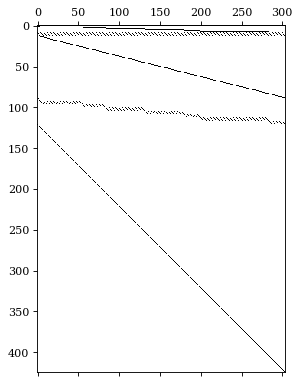

In [ ]:
#| hide
hplots = HierarchicalPlot(S=S_df, tags=tags)
hplots.plot_summing_matrix()

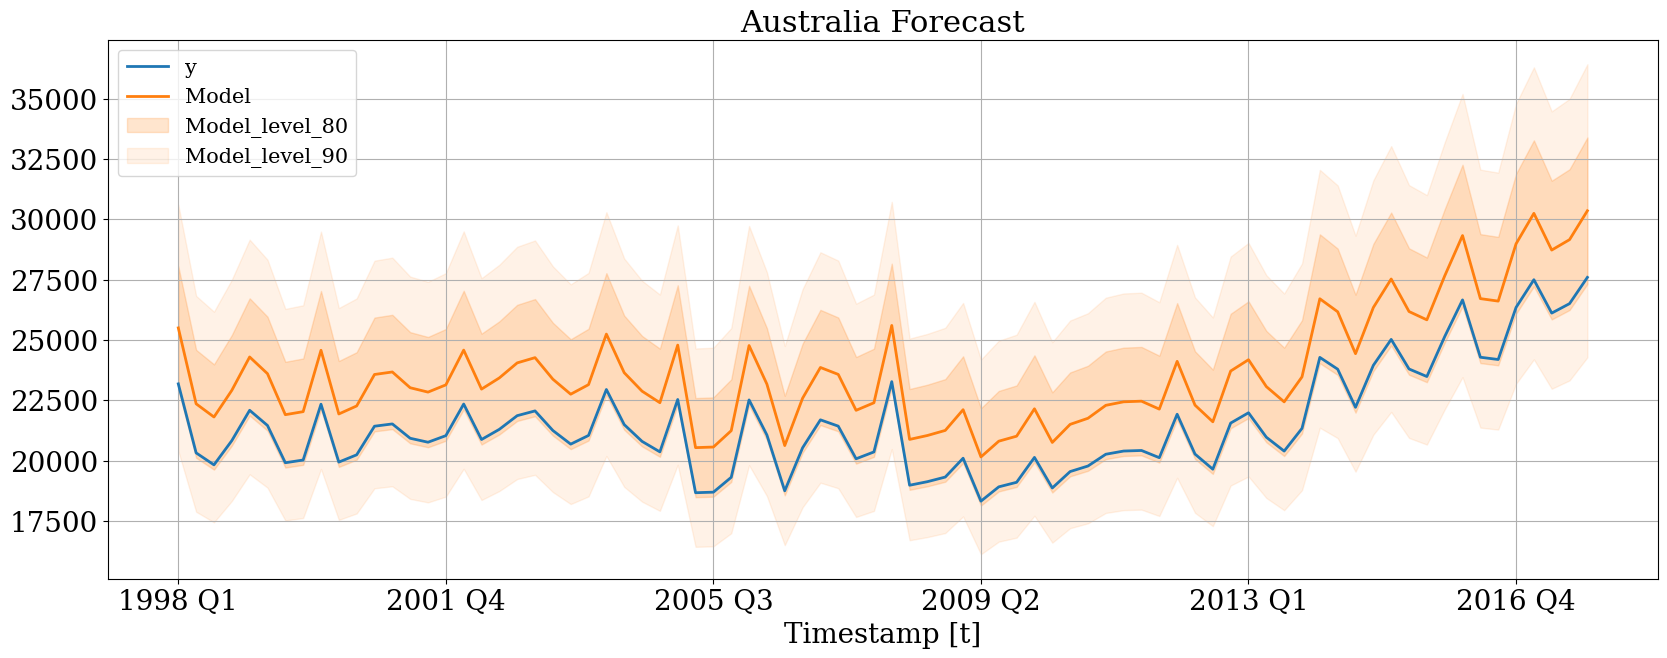

In [ ]:
#| hide
hier_df['Model'] = hier_df['y'] * 1.1
hier_df['Model-lo-80'] = hier_df['Model'] - 0.1 * hier_df['Model']
hier_df['Model-hi-80'] = hier_df['Model'] + 0.1 * hier_df['Model']
hier_df['Model-lo-90'] = hier_df['Model'] - 0.2 * hier_df['Model']
hier_df['Model-hi-90'] = hier_df['Model'] + 0.2 * hier_df['Model']
hplots.plot_series(
    series='Australia', 
    Y_df=hier_df,
    level=[80, 90]
)

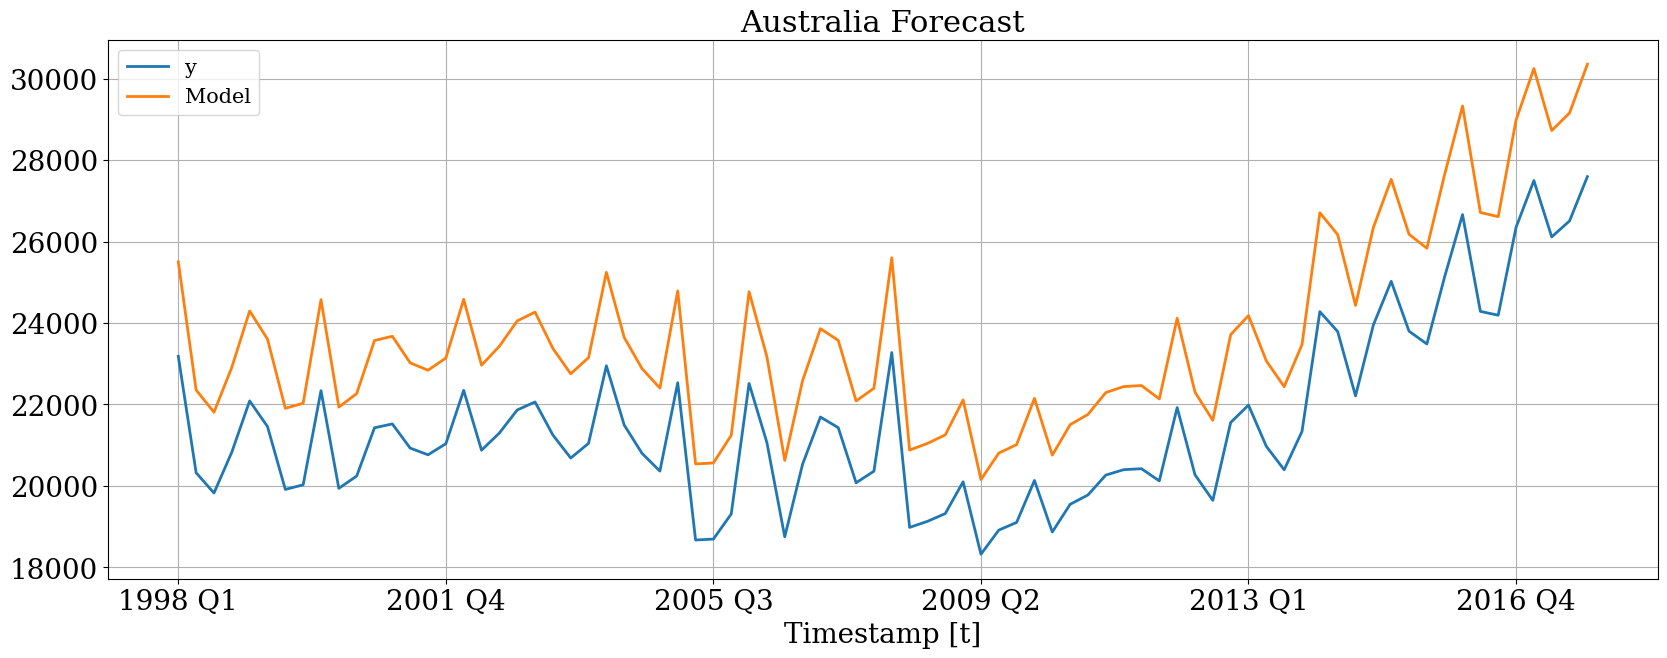

In [ ]:
#| hide
hplots.plot_series(series='Australia', 
                   Y_df=hier_df)

C:\Users\ospra\AppData\Local\Temp\ipykernel_11584\2028518223.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", 10)


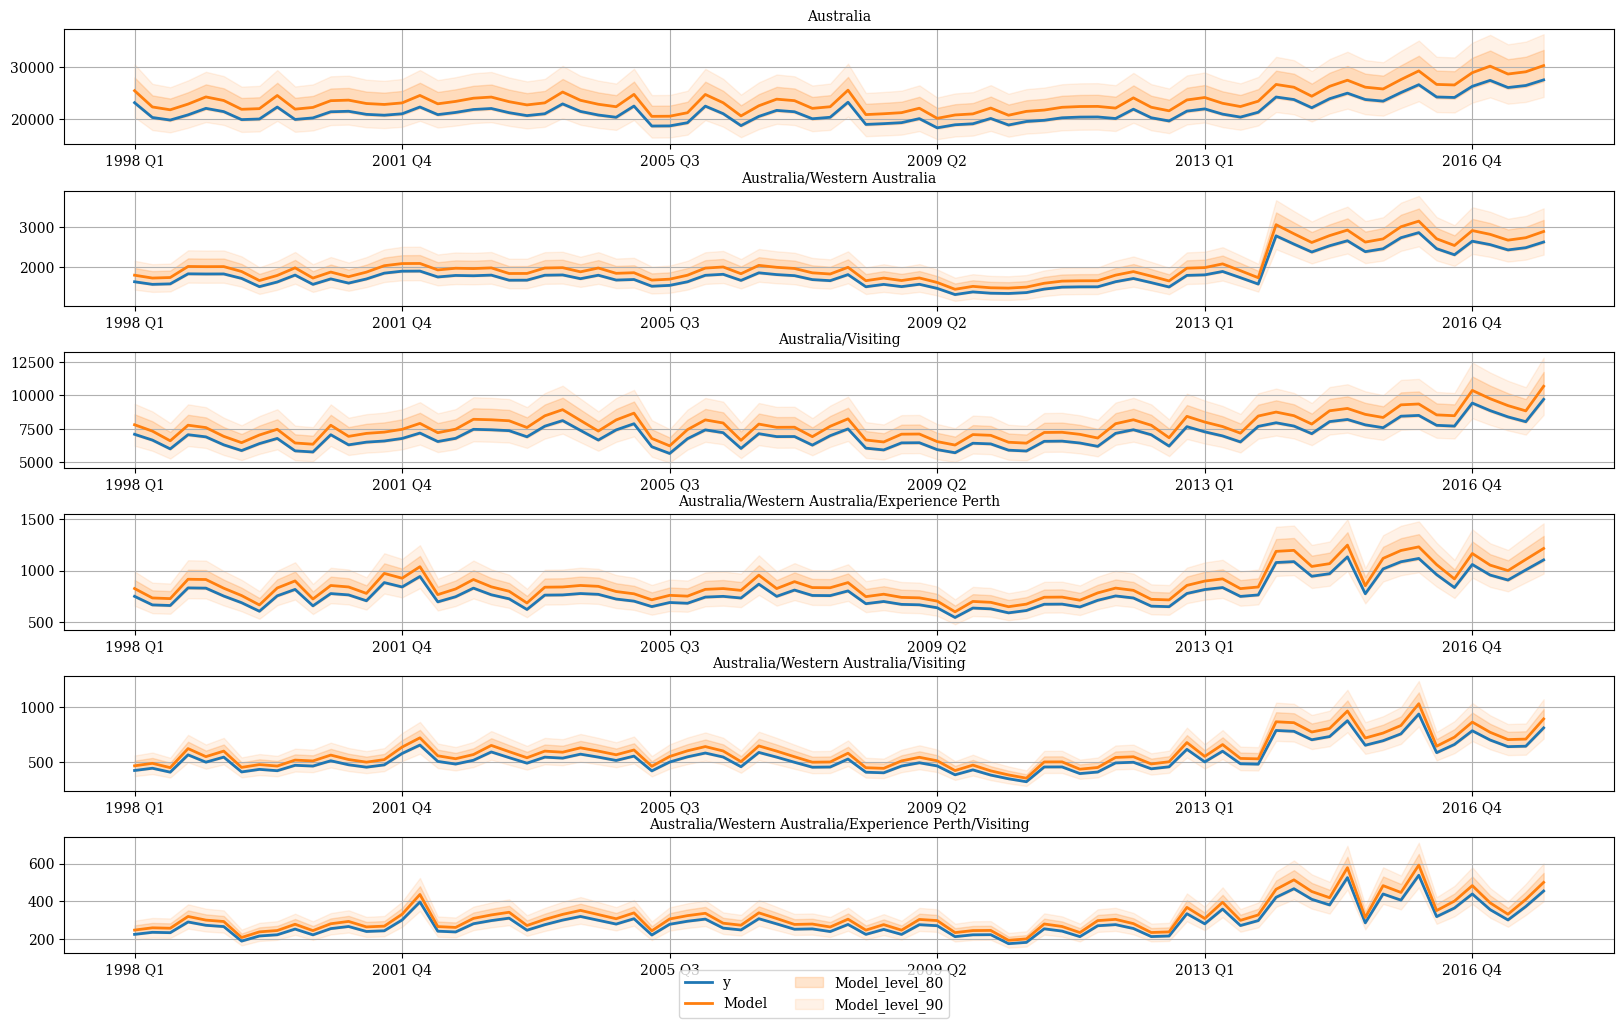

In [ ]:
#| hide
hplots.plot_hierarchically_linked_series(
    bottom_series='Australia/Western Australia/Experience Perth/Visiting', 
    Y_df=hier_df,
    level=[80, 90]
)

C:\Users\ospra\AppData\Local\Temp\ipykernel_11584\2028518223.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", 10)


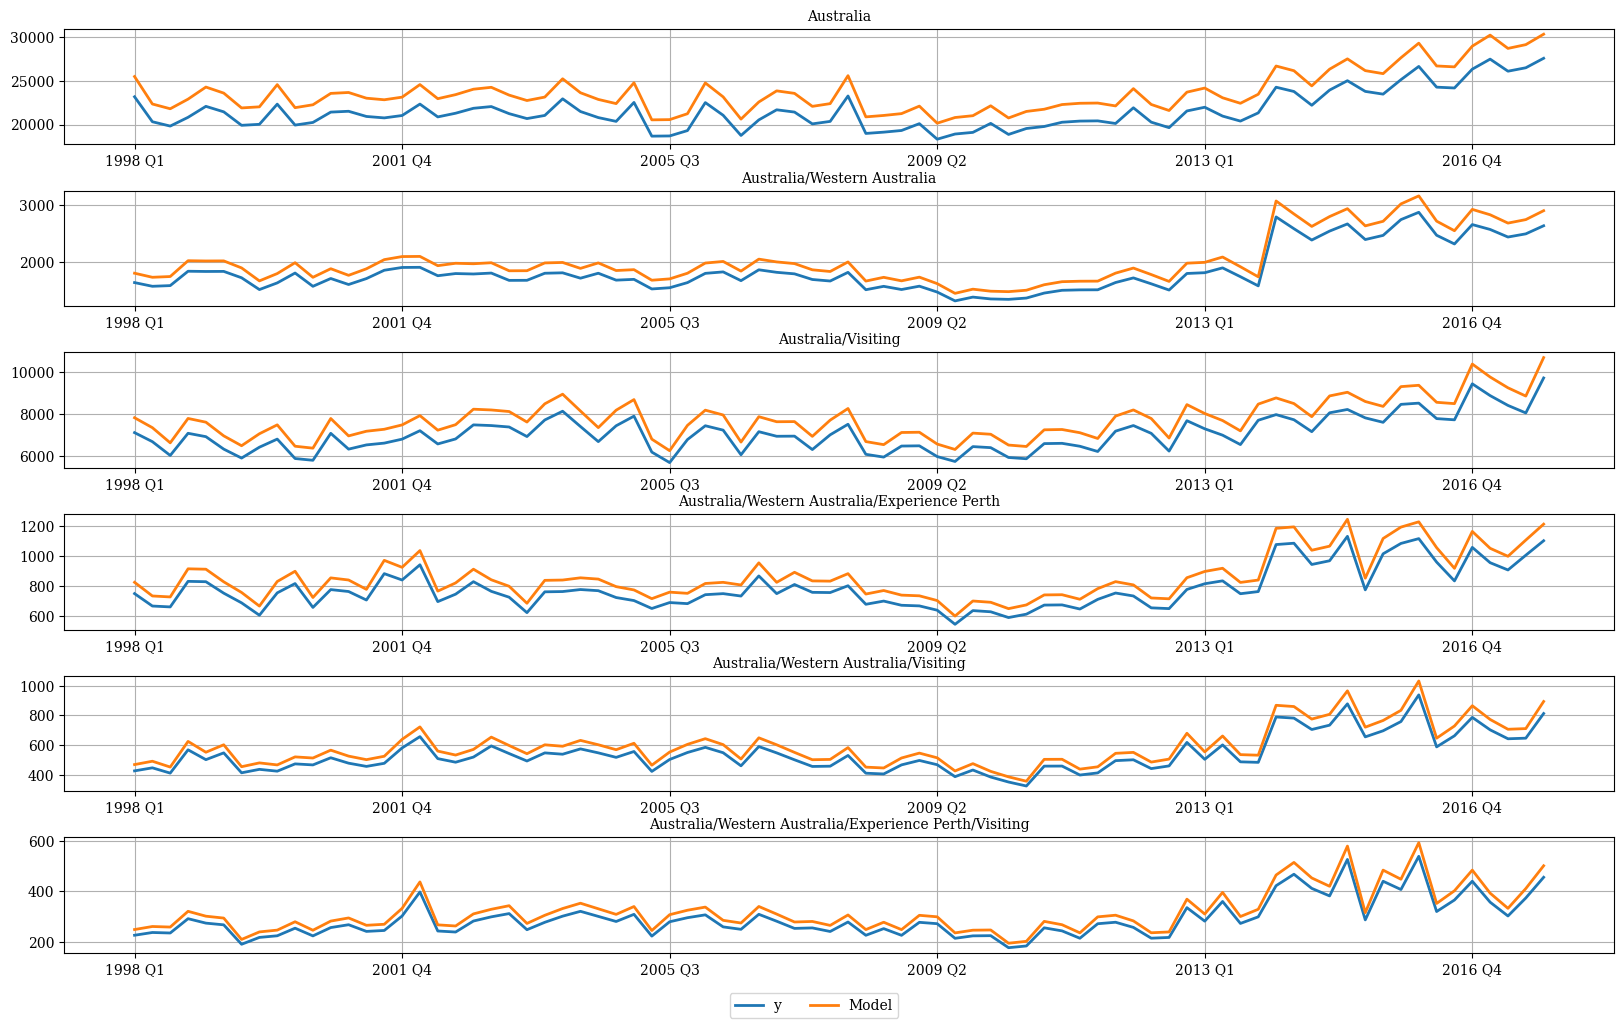

In [ ]:
#| hide
hplots.plot_hierarchically_linked_series(
    bottom_series='Australia/Western Australia/Experience Perth/Visiting', 
    Y_df=hier_df,
)

C:\Users\ospra\AppData\Local\Temp\ipykernel_11584\2028518223.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", 10)


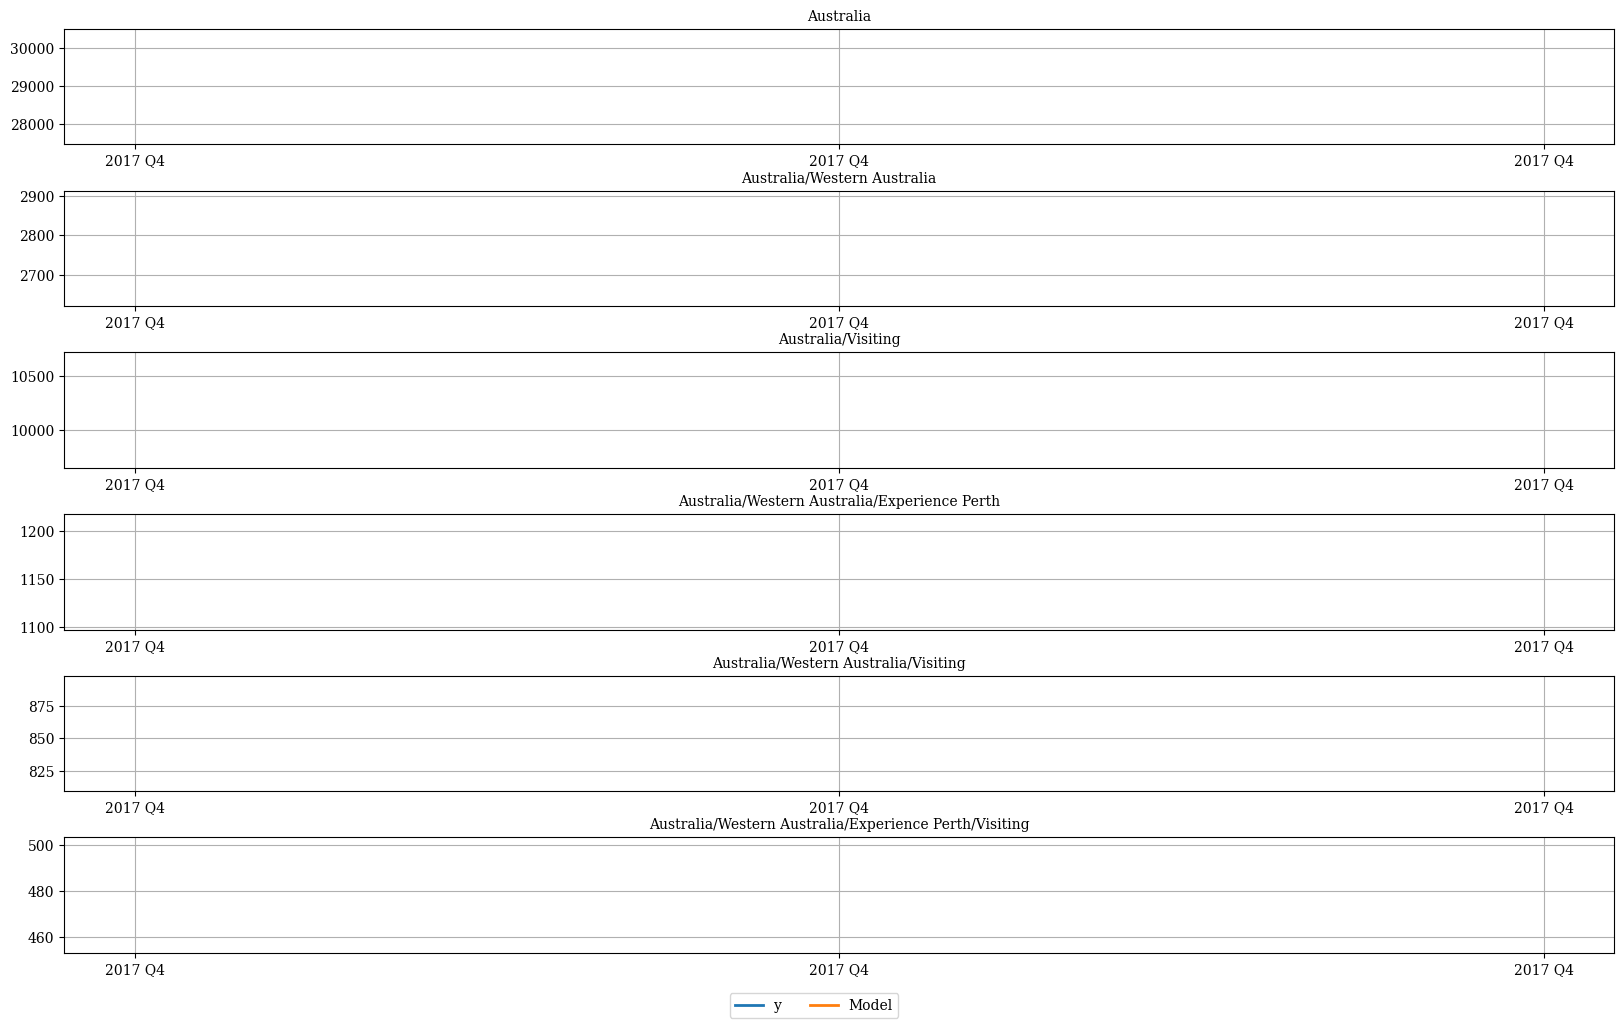

In [ ]:
#| hide
# test series with just one value
hplots.plot_hierarchically_linked_series(
    bottom_series='Australia/Western Australia/Experience Perth/Visiting', 
    Y_df=hier_df.groupby('unique_id').tail(1),
)

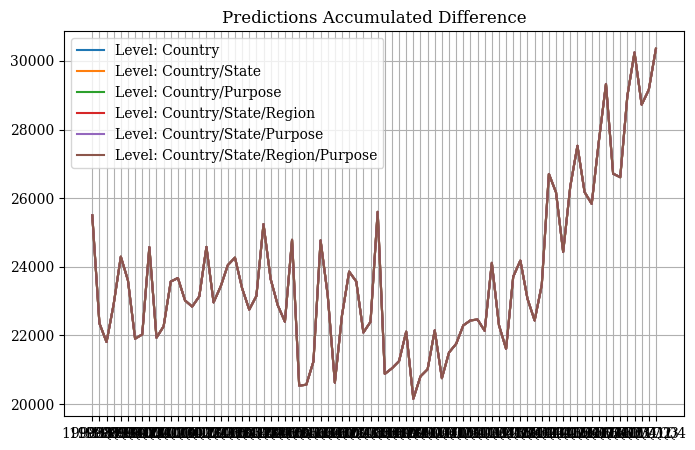

In [ ]:
#| hide
hplots.plot_hierarchical_predictions_gap(Y_df=hier_df.drop(columns='y'), models=['Model'])

c:\Users\ospra\miniconda3\envs\hierarchicalforecast\lib\site-packages\statsforecast\models.py:887: FutureWarning: `ETS` will be deprecated in future versions of `StatsForecast`. Please use `AutoETS` instead.
  ETS._warn()
c:\Users\ospra\miniconda3\envs\hierarchicalforecast\lib\site-packages\statsforecast\core.py:476: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
c:\Users\ospra\miniconda3\envs\hierarchicalforecast\lib\site-packages\statsforecast\core.py:628: FutureWarning: Passing unique_id as the index is deprecated. Please provide it as a column instead.
  warnings.warn(
c:\Users\ospra\miniconda3\envs\hierarchicalforecast\lib\site-packages\statsforecast\core.py:476: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing store

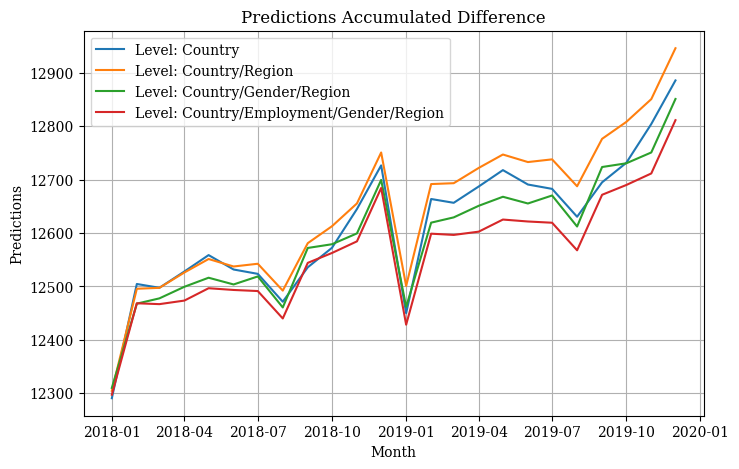

In [ ]:
#| eval: false
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, ETS, Naive
from datasetsforecast.hierarchical import HierarchicalData

Y_df, S, tags = HierarchicalData.load('./data', 'Labour')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

Y_test_df  = Y_df.groupby('unique_id').tail(24)
Y_train_df = Y_df.drop(Y_test_df.index)
Y_test_df  = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

fcst = StatsForecast(
    df=Y_train_df, 
    #models=[AutoARIMA(season_length=12), Naive()], 
    models=[ETS(season_length=12, model='AAZ')],
    freq='MS', 
    n_jobs=-1
)
Y_hat_df = fcst.forecast(h=24)

# Plot prediction difference of different aggregation
# Levels Country, Country/Region, Country/Gender/Region ...
hplots = HierarchicalPlot(S=S, tags=tags)

hplots.plot_hierarchical_predictions_gap(
    Y_df=Y_hat_df, models='ETS',
    xlabel='Month', ylabel='Predictions',
)

# External Forecast Adapters

In [ ]:
#| exporti

# convert levels to output quantile names
def level_to_outputs(level:Iterable[int]):
    """ Converts list of levels into output names matching StatsForecast and NeuralForecast methods.

    **Parameters:**<br>
    `level`: int list [0,100]. Probability levels for prediction intervals.<br>

    **Returns:**<br>
    `output_names`: str list. String list with output column names.
    """
    qs = sum([[50-l/2, 50+l/2] for l in level], [])
    output_names = sum([[f'-lo-{l}', f'-hi-{l}'] for l in level], [])

    sort_idx = np.argsort(qs)
    quantiles = np.array(qs)[sort_idx]

    # Add default median
    quantiles = np.concatenate([np.array([50]), quantiles]) / 100
    output_names = list(np.array(output_names)[sort_idx])
    output_names.insert(0, '-median')
    
    return quantiles, output_names

# convert quantiles to output quantile names
def quantiles_to_outputs(quantiles:Iterable[float]):
    """Converts list of quantiles into output names matching StatsForecast and NeuralForecast methods.

    **Parameters:**<br>
    `quantiles`: float list [0., 1.]. Alternative to level, quantiles to estimate from y distribution.<br>

    **Returns:**<br>
    `output_names`: str list. String list with output column names.
    """
    output_names = []
    for q in quantiles:
        if q<.50:
            output_names.append(f'-lo-{np.round(100-200*q,2)}')
        elif q>.50:
            output_names.append(f'-hi-{np.round(100-200*(1-q),2)}')
        else:
            output_names.append('-median')
    return quantiles, output_names

In [ ]:
#| exporti

# given input array of sample forecasts and inptut quantiles/levels, 
# output a Pandas Dataframe with columns of quantile predictions
def samples_to_quantiles_df(samples: np.ndarray, 
                            unique_ids: Sequence[str], 
                            dates: List[str], 
                            quantiles: Optional[List[float]] = None,
                            level: Optional[List[int]] = None, 
                            model_name: Optional[str] = "model"):
    """ Transform Random Samples into HierarchicalForecast input.
    Auxiliary function to create compatible HierarchicalForecast input `Y_hat_df` dataframe.

    **Parameters:**<br>
    `samples`: numpy array. Samples from forecast distribution of shape [n_series, n_samples, horizon].<br>
    `unique_ids`: string list. Unique identifiers for each time series.<br>
    `dates`: datetime list. List of forecast dates.<br>
    `quantiles`: float list in [0., 1.]. Alternative to level, quantiles to estimate from y distribution.<br>
    `level`: int list in [0,100]. Probability levels for prediction intervals.<br>
    `model_name`: string. Name of forecasting model.<br>

    **Returns:**<br>
    `quantiles`: float list in [0., 1.]. quantiles to estimate from y distribution .<br>
    `Y_hat_df`: pd.DataFrame. With base quantile forecasts with columns ds and models to reconcile indexed by unique_id.
    """
    
    # Get the shape of the array
    n_series, n_samples, horizon = samples.shape

    assert n_series == len(unique_ids)
    assert horizon == len(dates)
    assert (quantiles is not None) ^ (level is not None)  #check exactly one of quantiles/levels has been input

    #create initial dictionary
    forecasts_mean = np.mean(samples, axis=1).flatten()
    unique_ids = np.repeat(unique_ids, horizon)
    ds = np.tile(dates, n_series)
    data = pd.DataFrame({"unique_id":unique_ids, "ds":ds, model_name:forecasts_mean})

    #create quantiles and quantile names
    if level is not None:
        _quantiles, quantile_names = level_to_outputs(level)
    elif quantiles is not None:
        _quantiles, quantile_names = quantiles_to_outputs(quantiles)

    percentiles = [quantile * 100 for quantile in _quantiles]
    col_names = np.array([model_name + quantile_name for quantile_name in quantile_names])
    
    #add quantiles to dataframe
    forecasts_quantiles = np.percentile(samples, percentiles, axis=1)

    forecasts_quantiles = np.transpose(forecasts_quantiles, (1,2,0)) # [Q,H,N] -> [N,H,Q]
    forecasts_quantiles = forecasts_quantiles.reshape(-1,len(_quantiles))

    df = pd.DataFrame(data=forecasts_quantiles, 
                      columns=col_names)
    
    return _quantiles, pd.concat([data,df], axis=1).set_index('unique_id')

In [ ]:
show_doc(samples_to_quantiles_df, title_level=3)

---

[source](https://github.com/Nixtla/hierarchicalforecast/blob/main/hierarchicalforecast/utils.py#L506){target="_blank" style="float:right; font-size:smaller"}

### samples_to_quantiles_df

>      samples_to_quantiles_df (samples:numpy.ndarray, unique_ids:Sequence[str],
>                               dates:List[str],
>                               quantiles:Optional[List[float]]=None,
>                               level:Optional[List[int]]=None,
>                               model_name:Optional[str]='model')

*Transform Random Samples into HierarchicalForecast input.
Auxiliary function to create compatible HierarchicalForecast input `Y_hat_df` dataframe.

**Parameters:**<br>
`samples`: numpy array. Samples from forecast distribution of shape [n_series, n_samples, horizon].<br>
`unique_ids`: string list. Unique identifiers for each time series.<br>
`dates`: datetime list. List of forecast dates.<br>
`quantiles`: float list in [0., 1.]. Alternative to level, quantiles to estimate from y distribution.<br>
`level`: int list in [0,100]. Probability levels for prediction intervals.<br>
`model_name`: string. Name of forecasting model.<br>

**Returns:**<br>
`quantiles`: float list in [0., 1.]. quantiles to estimate from y distribution .<br>
`Y_hat_df`: pd.DataFrame. With base quantile forecasts with columns ds and models to reconcile indexed by unique_id.*

In [ ]:
#| hide

#level_to_outputs unit tests
test_eq(
    level_to_outputs([80, 90]),
    ([0.5 , 0.05, 0.1 , 0.9 , 0.95], ['-median', '-lo-90', '-lo-80', '-hi-80', '-hi-90'])
)
test_eq(
    level_to_outputs([30]),
    ([0.5 , 0.35, 0.65], ['-median', '-lo-30', '-hi-30'])
)
#quantiles_to_outputs unit tests
test_eq(
    quantiles_to_outputs([0.2, 0.4, 0.6, 0.8]),
    ([0.2,0.4,0.6, 0.8], ['-lo-60.0', '-lo-20.0', '-hi-20.0', '-hi-60.0'])
)
test_eq(
    quantiles_to_outputs([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]),
    ([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
     ['-lo-80.0', '-lo-60.0', '-lo-40.0', '-lo-20.0', '-median', '-hi-20.0', '-hi-40.0', '-hi-60.0', '-hi-80.0'])
)

In [ ]:
#| hide

#samples_to_quantiles_df unit tests
start_date = pd.Timestamp("2023-06-01")
end_date = pd.Timestamp("2023-06-10")
frequency = "D"  # Daily frequency
dates = pd.date_range(start=start_date, end=end_date, freq=frequency).tolist()
samples = np.random.rand(3, 200, 10)
unique_ids = ['id1', 'id2', 'id3']
level = np.array([10, 50, 90])
quantiles=np.array([0.5, 0.05, 0.25, 0.45, 0.55, 0.75, 0.95])

ret_quantiles_1, ret_df_1 = samples_to_quantiles_df(samples, unique_ids, dates, level=level)
ret_quantiles_2, ret_df_2 = samples_to_quantiles_df(samples, unique_ids, dates, quantiles=quantiles)

test_eq(
    ret_quantiles_1,
    quantiles
)
test_eq(
    ret_df_1.columns,
    ['ds', 'model', 'model-median', 'model-lo-90', 'model-lo-50', 'model-lo-10', 'model-hi-10', 'model-hi-50', 'model-hi-90']
)
test_eq(
    ret_df_1.index,
    ['id1', 'id1', 'id1', 'id1', 'id1', 'id1', 'id1', 'id1', 'id1', 'id1',
       'id2', 'id2', 'id2', 'id2', 'id2', 'id2', 'id2', 'id2', 'id2', 'id2',
       'id3', 'id3', 'id3', 'id3', 'id3', 'id3', 'id3', 'id3', 'id3', 'id3']
)
test_eq(
    ret_quantiles_1, ret_quantiles_2
)
test_eq(
    ret_df_1.index, ret_df_2.index
)

In [ ]:
#| hide

#Unit test for the aggregate function accounting for exog_vars

df = pd.DataFrame(
    {
        'cat1': ['a', 'a', 'c'],
        'cat2': ['1', '2', '3'],
        'exog1': [4, 5, 6],
        'exog2': [7, 6, 5],
        'y': [10, 20, 30],
        'ds': ['2020-01-01', '2020-02-01', '2020-03-01']
    }
)
spec = [["cat1"],["cat1","cat2"]]


Y_df_check = pd.DataFrame(
    data={
        
        'ds': ['2020-01-01','2020-02-01','2020-03-01','2020-01-01','2020-02-01','2020-03-01'],
        'y': [10, 20, 30, 10, 20, 30],
    },
    index=['a', 'a', 'c', 'a/1', 'a/2', 'c/3'],
)
Y_df_check.index.name = 'unique_id'

S_df_check = pd.DataFrame(
    data={
        'a/1': np.array([1.0, 0.0, 1.0, 0.0, 0.0], dtype=np.float64),
        'a/2': np.array([1.0, 0.0, 0.0, 1.0, 0.0], dtype=np.float64),
        'c/3': np.array([0.0, 1.0, 0.0, 0.0, 1.0], dtype=np.float64)
    },
    index=['a', 'c', 'a/1', 'a/2', 'c/3']
)


Y_df_check_exog = pd.DataFrame(
    data = {
        'ds': ['2020-01-01', '2020-02-01', '2020-03-01', '2020-01-01', '2020-02-01', '2020-03-01'],
        'y': [10, 20, 30, 10, 20, 30],
        'exog1_mean': [4.0, 5.0, 6.0, 4.0, 5.0, 6.0],
        'exog2_sum': [7, 6, 5, 7, 6, 5]
    },
    index = ['a', 'a', 'c', 'a/1', 'a/2', 'c/3']
)
Y_df_check_exog.index.name = 'unique_id'

Y_df, S_df, tags = aggregate(
    df = df,
    spec = spec,
    exog_vars = None,
)

Y_df_exog, S_df_exog, tags = aggregate(
    df = df,
    spec = spec,
    exog_vars = {'exog1':'mean','exog2':'sum'},
)

test_eq(Y_df, 
        Y_df_check)

test_eq(S_df, 
        S_df_check)

test_eq(Y_df_exog,
        Y_df_check_exog)

# Numba functions

In [ ]:
#| exporti

# Masked empirical covariance matrix
@njit("Array(float64, 2, 'F')(Array(float64, 2, 'C'), Array(bool, 2, 'C'))", nogil=NUMBA_NOGIL, cache=NUMBA_CACHE, parallel=NUMBA_PARALLEL, fastmath=NUMBA_FASTMATH, error_model="numpy")
# @njit(nogil=NOGIL, cache=CACHE, parallel=True, fastmath=True, error_model="numpy")
def _ma_cov(residuals: np.ndarray, not_nan_mask: np.ndarray):
    """Masked empirical covariance matrix.

    :meta private:
    """
    n_timeseries = residuals.shape[0]
    W = np.zeros((n_timeseries, n_timeseries), dtype=np.float64).T
    for i in prange(n_timeseries):
        not_nan_mask_i = not_nan_mask[i]
        for j in range(i + 1):
            not_nan_mask_j = not_nan_mask[j]
            not_nan_mask_ij = not_nan_mask_i & not_nan_mask_j   
            n_samples = np.sum(not_nan_mask_ij)
            # Only compute if we have enough non-nan samples in the time series pair
            if n_samples > 1:
                # Masked residuals
                residuals_i = residuals[i][not_nan_mask_ij]
                residuals_j = residuals[j][not_nan_mask_ij]
                residuals_i_mean = np.mean(residuals_i)
                residuals_j_mean = np.mean(residuals_j)
                X_i = (residuals_i - residuals_i_mean)
                X_j = (residuals_j - residuals_j_mean)
                # Empirical covariance
                factor_emp_cov = np.float64(1 / (n_samples - 1))
                W[i, j] = W[j, i] = factor_emp_cov * np.sum(X_i * X_j)

    return W

In [ ]:
#| exporti

# Shrunk covariance matrix using the Schafer-Strimmer method

@njit("Array(float64, 2, 'F')(Array(float64, 2, 'C'), float64)", nogil=NUMBA_NOGIL, cache=NUMBA_CACHE, parallel=NUMBA_PARALLEL, fastmath=NUMBA_FASTMATH, error_model="numpy")
def _shrunk_covariance_schaferstrimmer_no_nans(residuals: np.ndarray, mint_shr_ridge: float):
    """Shrink empirical covariance according to the following method:
        Schäfer, Juliane, and Korbinian Strimmer. 
        ‘A Shrinkage Approach to Large-Scale Covariance Matrix Estimation and 
        Implications for Functional Genomics’. Statistical Applications in 
        Genetics and Molecular Biology 4, no. 1 (14 January 2005). 
        https://doi.org/10.2202/1544-6115.1175.

    :meta private:
    """
    n_timeseries = residuals.shape[0]
    n_samples = residuals.shape[1]
    
    # We need the empirical covariance, the off-diagonal sum of the variance of 
    # the empirical correlation matrix and the off-diagonal sum of the squared 
    # empirical correlation matrix.
    W = np.zeros((n_timeseries, n_timeseries), dtype=np.float64).T
    sum_var_emp_corr = np.float64(0.0)
    sum_sq_emp_corr = np.float64(0.0)
    factor_emp_cov = np.float64(1 / (n_samples - 1))
    factor_shrinkage = np.float64(1 / (n_samples * (n_samples - 1)))
    epsilon = np.float64(2e-8)
    for i in prange(n_timeseries):
        # Mean of the standardized residuals
        X_i = residuals[i] - np.mean(residuals[i])
        Xs_i = X_i / (np.std(residuals[i]) + epsilon)
        Xs_i_mean = np.mean(Xs_i)
        for j in range(i + 1):
            # Empirical covariance
            X_j = residuals[j] - np.mean(residuals[j])
            W[i, j] = factor_emp_cov * np.sum(X_i * X_j)
            # Off-diagonal sums
            if i != j:
                Xs_j = X_j / (np.std(residuals[j]) + epsilon)
                Xs_j_mean = np.mean(Xs_j)
                # Sum off-diagonal variance of empirical correlation
                w = (Xs_i - Xs_i_mean) * (Xs_j - Xs_j_mean)
                w_mean = np.mean(w)
                sum_var_emp_corr += np.sum(np.square(w - w_mean))
                # Sum squared empirical correlation
                sum_sq_emp_corr += w_mean**2

    # Calculate shrinkage intensity 
    shrinkage = 1.0 - max(min((factor_shrinkage * sum_var_emp_corr) / (sum_sq_emp_corr + epsilon), 1.0), 0.0)
    # Shrink the empirical covariance
    for i in prange(n_timeseries):
        for j in range(i + 1):
            if i != j:    
                W[i, j] = W[j, i] = shrinkage * W[i, j]
            else:
                W[i, j] = W[j, i] = max(W[i, j], mint_shr_ridge)
    return W

@njit("Array(float64, 2, 'F')(Array(float64, 2, 'C'), Array(bool, 2, 'C'), float64)", nogil=NUMBA_NOGIL, cache=NUMBA_CACHE, parallel=NUMBA_PARALLEL, fastmath=NUMBA_FASTMATH, error_model="numpy")
def _shrunk_covariance_schaferstrimmer_with_nans(residuals: np.ndarray, not_nan_mask: np.ndarray, mint_shr_ridge: float):
    """Shrink empirical covariance according to the following method:
        Schäfer, Juliane, and Korbinian Strimmer. 
        ‘A Shrinkage Approach to Large-Scale Covariance Matrix Estimation and 
        Implications for Functional Genomics’. Statistical Applications in 
        Genetics and Molecular Biology 4, no. 1 (14 January 2005). 
        https://doi.org/10.2202/1544-6115.1175.

    :meta private:
    """
    n_timeseries = residuals.shape[0]
    
    # We need the empirical covariance, the off-diagonal sum of the variance of 
    # the empirical correlation matrix and the off-diagonal sum of the squared 
    # empirical correlation matrix.
    W = np.zeros((n_timeseries, n_timeseries), dtype=np.float64).T
    sum_var_emp_corr = np.float64(0.0)
    sum_sq_emp_corr = np.float64(0.0)
    epsilon = np.float64(2e-8)
    for i in prange(n_timeseries):
        not_nan_mask_i = not_nan_mask[i]
        for j in range(i + 1):
            not_nan_mask_j = not_nan_mask[j]
            not_nan_mask_ij = not_nan_mask_i & not_nan_mask_j   
            n_samples = np.sum(not_nan_mask_ij)
            # Only compute if we have enough non-nan samples in the time series pair
            if n_samples > 1:
                # Masked residuals
                residuals_i = residuals[i][not_nan_mask_ij]
                residuals_j = residuals[j][not_nan_mask_ij]
                residuals_i_mean = np.mean(residuals_i)
                residuals_j_mean = np.mean(residuals_j)
                X_i = (residuals_i - residuals_i_mean)
                X_j = (residuals_j - residuals_j_mean)
                # Empirical covariance
                factor_emp_cov = np.float64(1 / (n_samples - 1))
                W[i, j] = factor_emp_cov * np.sum(X_i * X_j)
                # Off-diagonal sums
                if i != j:
                    factor_var_emp_cor = np.float64(n_samples / (n_samples - 1)**3)
                    residuals_i_std = np.std(residuals_i) + epsilon
                    residuals_j_std = np.std(residuals_j) + epsilon
                    Xs_i = X_i / (residuals_i_std + epsilon)
                    Xs_j = X_j / (residuals_j_std + epsilon)
                    Xs_im_mean = np.mean(Xs_i)
                    Xs_jm_mean = np.mean(Xs_j)
                    # Sum off-diagonal variance of empirical correlation
                    w = (Xs_i - Xs_im_mean) * (Xs_j - Xs_jm_mean)
                    w_mean = np.mean(w)
                    sum_var_emp_corr += factor_var_emp_cor * np.sum(np.square(w - w_mean))
                    # Sum squared empirical correlation
                    sum_sq_emp_corr += np.square(factor_emp_cov * n_samples * w_mean)

    # Calculate shrinkage intensity 
    shrinkage = 1.0 - max(min((sum_var_emp_corr) / (sum_sq_emp_corr + epsilon), 1.0), 0.0)

    # Shrink the empirical covariance
    for i in prange(n_timeseries):
        for j in range(i + 1):
            if i != j:    
                W[i, j] = W[j, i] = shrinkage * W[i, j]
            else:
                W[i, j] = W[j, i] = max(W[i, j], mint_shr_ridge)

    return W

In [ ]:
#| hide
# test covariance equivalence
n_samples = 100
n_hiers = 10
y_insample = np.random.rand(n_samples, n_hiers)
y_hat_insample = np.random.rand(n_samples, n_hiers)
residuals = (y_insample - y_hat_insample)
nan_mask = np.isnan(residuals)

# Check equivalence of covariance functions in case of no nans
W_nb = _ma_cov(residuals, ~nan_mask)
W_np = np.cov(residuals)
np.testing.assert_allclose(W_nb, W_np, atol=1e-6)

# Check equivalence of shrunk covariance functions in case of no nans
W_ss_nonan = _shrunk_covariance_schaferstrimmer_no_nans(residuals, 2e-8)
W_ss_nan = _shrunk_covariance_schaferstrimmer_with_nans(residuals, ~nan_mask, 2e-8)
np.testing.assert_allclose(W_ss_nan, W_ss_nonan, atol=1e-6)

# Check equivalence of diagonal elements of shrunk W to non-shrunk W in case of no nans
np.testing.assert_allclose(np.diag(W_np), np.diag(W_ss_nan), atol=1e-6)

In [ ]:
#| exporti

# Lasso cyclic coordinate descent
@njit("Array(float64, 1, 'C')(Array(float64, 2, 'C'), Array(float64, 1, 'C'), float64, int64, float64)", nogil=NUMBA_NOGIL, cache=NUMBA_CACHE, fastmath=NUMBA_FASTMATH, error_model="numpy")
def _lasso(X: np.ndarray, y: np.ndarray, 
          lambda_reg: float, max_iters: int = 1_000,
          tol: float = 1e-4):
    # lasso cyclic coordinate descent
    n, feats = X.shape
    norms = np.sum(X ** 2, axis=0)
    beta = np.zeros(feats, dtype=np.float64)
    beta_changes = np.zeros(feats, dtype=np.float64)
    residuals = y.copy()

    for it in range(max_iters):
        for i in range(feats):            
            norms_i = norms[i]
            # is feature is close to zero, we 
            # continue to the next.
            # in this case is optimal betai= 0
            if abs(norms_i) < 1e-8:
                continue
            beta_i = beta[i]

            #we calculate the normalized derivative
            rho = beta_i
            for j in range(n):
                rho += X[j, i] * residuals[j] / norms_i

            #soft threshold
            beta_i_next = np.sign(rho) * max(np.abs(rho) - lambda_reg * n / norms_i, 0.)#(norms[i] + 1e-3), 0.)
            beta_delta = beta_i_next - beta_i
            beta_changes[i] = np.abs(beta_delta)
            if beta_delta != 0.0:
                for j in range(n):
                    residuals[j] += beta_delta * X[j, i]

                beta[i] = beta_i_next
        
        if max(beta_changes) < tol:
            break

    return beta